In [1]:
using TaylorSeries

In [2]:
using Compat

In [3]:
const _ordenTaylor = 28 #Entiendo que este se puede cambiar de acuerdo con el problema
const _epsAbs = 1.0e-20 #Epsilon de la máquina.
GM1=1.0
GM2=2.0

2.0

In [4]:
function IniCond(g::Float64)
    x0=5.0
    y0=5.0
    vx0=0.0
    vy0=0.0
    return x0,y0,vx0,vy0
end

IniCond (generic function with 1 method)

In [5]:
function taylorStepper{T<:Real}( jetEqs::Function, vec0::Array{T,1} ) #Las entradas serán una función y un vector 
    #cuyas entradas serán las condiciones iniciales de velocidad y posición en x y en y
    n = length( vec0 )
    vec0T = Array(Taylor1{T},n)
    @simd for i in eachindex(vec0)
        @inbounds vec0T[i] = Taylor1([vec0[i]], _ordenTaylor)
    end
    #Lo que entiendo de esta parte es que a cada entrada de vec0 se le convierte a formato de serie de Taylor.
    #vec0T será un vector cuyas entradas son series de Taylor y las componentes independientes de cada uno de ellas
    #son las componentes iniciales. Por ejemplo: vec0T=[x0+ ϑ(t²⁹),y0+ϑ(t²⁹),v0x+ϑ(t²⁹),v0y+ϑ(t²⁹)]
    vec1T = jetEqs( vec0 )
    #Aplicamos la función jetEqs a vec0.
    #Creo que esta es la que va a construir el resto de los coeficientes de cada serie.
    hh = Inf
    @simd for i in eachindex(vec1T)
        @inbounds h1 = stepsize( vec1T[i], _epsAbs ) #Stepsize regresa el error. Esta parte da un valor de h para 
        #cada una de las 4 series que se encuentran en el arreglo.
        hh = min( hh, h1 ) #Supongo que esto es para asegurarnos que el valor h1 no sea infinito.
    end
    
    @simd for i in eachindex(vec0)
        @inbounds vec0[i] = evaluate( vec1T[i], hh ) #Evalúa vec1T (obtenido de Jeteqs) en el valor de error
        #y lo coloca en la entrada correspondiente de vec0 (donde teníamos los valores iniciales). Supongo que ahora
        #el vec0 es el valor de las posiciones y velocidades evaluadas en el tiempo hh. (es el primer avance en el
        #tiempo)
    end
    
    return hh, vec0
end

taylorStepper (generic function with 1 method)

In [6]:
#Calcula el tamaño del paso
function stepsize{T<:Real}(x::Taylor1{T}, epsilon::Float64)
    #Tiene como entradas una serie de Taylor y la epsilon de la máquina
    ord = x.order
    h = Inf
    for k in [ord-1, ord] #De las dos últimas entradas 
        kinv = 1.0/k
        aux = abs(x.coeffs[k+1])
        h = min(h, (epsilon/aux)^kinv)
        #Literalmente sigue la fórmula del valor h
    end
    return h
end

stepsize (generic function with 1 method)

In [12]:
function jet{T<:Real}( vec::Array{T,1} )

    s=10.0
    xT = Taylor1(vec[1], _ordenTaylor)
    yT = Taylor1(vec[2], _ordenTaylor)
    vxT = Taylor1(vec[3], _ordenTaylor)
    vyT = Taylor1(vec[4], _ordenTaylor)
    #Se guardan los valores iniciales en el lugar del término independiente. Pero a medida que avanza el loop de
    #abajo, se van llenando en estas variables, el resto de los términos de la serie de Taylor.
    for k = 0:_ordenTaylor-1
        knext = k+1 #Esto se necesita por el hecho de empezar desde cero.

        xTt = Taylor1( xT.coeffs[1:k+1], k) #Se "copian" los términos de la serie que ya se tenían
        yTt = Taylor1( yT.coeffs[1:k+1], k)
        vxTt = Taylor1( vxT.coeffs[1:k+1], k)
        vyTt = Taylor1( vyT.coeffs[1:k+1], k)
        
        xDot = vxTt #Se escriben las ecuaciones de movimiento.
        yDot = vyTt
        rrt = ( xTt^2 + yTt^2 )^(3/2)
        rrt1=((xTt)^2 + yTt^2 )^(3/2)
        vxDot = -GM1 * ((xTt / rrt))
        vyDot = -GM1 * (yTt / rrt)
        
        xT.coeffs[knext+1]  = xDot.coeffs[knext] / knext #Con formulazo, se calculan los siguientes coeficientes de 
        yT.coeffs[knext+1]  = yDot.coeffs[knext] / knext #cada serie.
        vxT.coeffs[knext+1] = vxDot.coeffs[knext] / knext
        vyT.coeffs[knext+1] = vyDot.coeffs[knext] / knext
    end
    
    return Taylor1[ xT, yT, vxT, vyT ]
end

jet (generic function with 1 method)

In [8]:
function keplerIntegration(time_max::Float64, jetEqs::Function )
    # Initial conditions, energy and angular momentum
    t0 = 0.0
    x0, y0, vx0, vy0 = IniCond(1.0)

    tV, xV, yV, vxV, vyV = Float64[], Float64[], Float64[], Float64[], Float64[]
    push!(tV, t0)
    push!(xV, x0)
    push!(yV, y0)
    push!(vxV, vx0)
    push!(vyV, vy0)

    
    # This is the main loop; we include a minimum step size for security
    dt = 1.0
    while t0 < time_max && dt>1.0e-8
        # Here we integrate
        dt, (x1, y1, vx1, vy1) = taylorStepper( jetEqs, [x0, y0, vx0, vy0] ); #Hacer esto una vez significa obtener
        #las series evaluadas en el tiempo t0. Se obtienen velocidades y posiciones en x y en y.
        t0 += dt #Avanzar en el tiempo y volverlo a hacer (con el while)
        push!(tV,t0) #Supongo que ir llenando los arrays
        push!(xV,x1)
        push!(yV,y1)
        push!(vxV, vx1)
        push!(vyV, vy1)
        x0, y0, vx0, vy0 = x1, y1, vx1, vy1
    end

    return tV, xV, yV
end

keplerIntegration (generic function with 1 method)

In [15]:
t,x,y=keplerIntegration(100.00, jet)

([0.0,4.35217,7.87774,10.6439,12.8159,14.5225,15.8643,16.9203,17.7518,18.407  …  20.8849,20.8849,20.8849,20.8849,20.8849,20.8849,20.8849,20.8849,20.8849,20.8849],[5.0,4.86484,4.54744,4.15016,3.72882,3.31423,2.92296,2.56315,2.23797,1.94765  …  4.6195e-5,4.07657e-5,3.59859e-5,3.17766e-5,2.80685e-5,2.48009e-5,2.19205e-5,1.93806e-5,1.71403e-5,1.51636e-5],[5.0,4.86484,4.54744,4.15016,3.72882,3.31423,2.92296,2.56315,2.23797,1.94765  …  4.6195e-5,4.07657e-5,3.59859e-5,3.17766e-5,2.80685e-5,2.48009e-5,2.19205e-5,1.93806e-5,1.71403e-5,1.51636e-5])

In [10]:
using PyPlot

INFO: Loading help data...


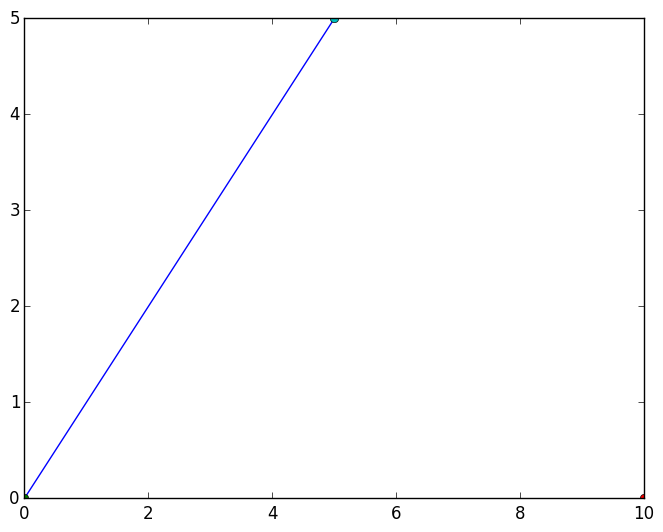

4-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe4d891d4d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fe4d891d750>
 PyObject <matplotlib.lines.Line2D object at 0x7fe4d891ddd0>
 PyObject <matplotlib.lines.Line2D object at 0x7fe4d8929410>

In [16]:
plot(x,y,[0],[0],"o",[10],[0],"o",[5],[5],"o")